The purpose of the demo is to show a sample of ML capabilities in Viya VDMML using the jupyter interface. We create a **ML pipeline to train and compare models for churn detection**.

In this demo we will
1. First read data into a into a Pandas data frame on the client laptop
2. Then uploaded to the CAS server(s)
3. We'll then do some simple Data Manipulation steps to show SQL capabilities
4. Build Classification models (Logistic Regression and Random Forest)
5. Score Data
6. Assess Models
7. Compare their performance

In [4]:
import swat,_config,pygal
from swat.render import render_html
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)
from matplotlib import pyplot as plt
from IPython.display import HTML
%matplotlib inline
from ggplot import *

In [5]:
user,pswd = _config.login()
host='racesx09013.demo.sas.com'
portnum=8777 #REST port
conn = swat.CAS(host,portnum,user,pswd,protocol='http')

Load into pandas and check out the columns

In [6]:
#Load the data set into a pandas dataframe
churn_df=pd.read_csv('C:\\Users\\sagang\\OneDrive - SAS\\Public\\data\\churn.csv')
#Clean print column names
for i in churn_df.columns : print(i)

Account Length
VMail Message
Day Mins
Eve Mins
Night Mins
Intl Mins
CustServ Calls
Churn
Int'l Plan
VMail Plan
Day Calls
Day Charge
Eve Calls
Eve Charge
Night Calls
Night Charge
Intl Calls
Intl Charge
State
Area Code
Phone


Clearly, we want to rename some of these columns

In [7]:
#remove/replace special characters and white spaces
churn_df.columns = [i.replace(' ','_').replace("'",'').lower() for i in churn_df.columns]
#Check out how the resultant dataset look like
churn_df.head()

,account_length,vmail_message,day_mins,eve_mins,night_mins,intl_mins,custserv_calls,churn,intl_plan,vmail_plan,...,day_charge,eve_calls,eve_charge,night_calls,night_charge,intl_calls,intl_charge,state,area_code,phone
0,128,25,265.10,197.40,244.70,10.00,1,0,0,1,...,45.07,99,16.78,91,11.01,3,2.70,KS,415,382-4657
1,107,26,161.60,195.50,254.40,13.70,1,0,0,1,...,27.47,103,16.62,103,11.45,3,3.70,OH,415,371-7191
2,137,0,243.40,121.20,162.60,12.20,0,0,0,0,...,41.38,110,10.30,104,7.32,5,3.29,NJ,415,358-1921
3,84,0,299.40,61.90,196.90,6.60,2,0,1,0,...,50.90,88,5.26,89,8.86,7,1.78,OH,408,375-9999
4,75,0,166.70,148.30,186.90,10.10,3,0,1,0,...,28.34,122,12.61,121,8.41,3,2.73,OK,415,330-6626


Load data into CAS from the client and examine the resulting CASResults Object

In [8]:
out=conn.upload(churn_df,casout=dict(name='churn',caslib='casuser'))
out

NOTE: Cloud Analytic Services made the uploaded file available as table CHURN in caslib CASUSER(sasdemo).
NOTE: The table CHURN has been created in caslib CASUSER(sasdemo) from binary data uploaded to Cloud Analytic Services.


[caslib]

 'CASUSER(sasdemo)'

[tableName]

 'CHURN'

[casTable]

 CASTable('CHURN', caslib='CASUSER(sasdemo)')

+ Elapsed: 0.363s, user: 0.027s, sys: 0.013s, mem: 17.1mb

Check out the CAS Table

In [9]:
out=out.casTable
render_html(out.fetch(to=5))

Selected Rows from Table CHURN 
 account_length 
 vmail_message 
 day_mins 
 eve_mins 
 night_mins 
 intl_mins 
 custserv_calls 
 churn 
 intl_plan 
 vmail_plan 
 day_calls 
 day_charge 
 eve_calls 
 eve_charge 
 night_calls 
 night_charge 
 intl_calls 
 intl_charge 
 state 
 area_code 
 phone 
 
 
 128.0 25.0 265.1 197.4 244.7 10.0 1.0 0.0 0.0 1.0 110.0 45.07 99.0 16.78 91.0 11.01 3.0 2.7 KS 415.0 382-4657 
 107.0 26.0 161.6 195.5 254.4 13.7 1.0 0.0 0.0 1.0 123.0 27.47 103.0 16.62 103.0 11.45 3.0 3.7 OH 415.0 371-7191 
 137.0 0.0 243.4 121.2 162.6 12.2 0.0 0.0 0.0 0.0 114.0 41.38 110.0 10.3 104.0 7.32 5.0 3.29 NJ 415.0 358-1921 
 84.0 0.0 299.4 61.9 196.9 6.6 2.0 0.0 1.0 0.0 71.0 50.9 88.0 5.26 89.0 8.86 7.0 1.78 OH 408.0 375-9999 
 75.0 0.0 166.7 148.3 186.9 10.1 3.0 0.0 1.0 0.0 113.0 28.34 122.0 12.61 121.0 8.41 3.0 2.73 OK 415.0 330-6626

In [10]:
out.dtypes

account_length     double
vmail_message      double
day_mins           double
eve_mins           double
night_mins         double
intl_mins          double
custserv_calls     double
churn              double
intl_plan          double
vmail_plan         double
day_calls          double
day_charge         double
eve_calls          double
eve_charge         double
night_calls        double
night_charge       double
intl_calls         double
intl_charge        double
state             varchar
area_code          double
phone             varchar
dtype: object

We notice two things that ought to be done here. The data type for `churn` and `area_code` variables should not be double. Let's change that by using some SQL on the in memory table. 

In [11]:
#Enable SQL actions
conn.loadactionset('fedSQL')

NOTE: Added action set 'fedSQL'.


[actionset]

 'fedSQL'

+ Elapsed: 0.0436s, user: 0.001s, sys: 0.004s, mem: 0.0782mb

 <font size=2px> **Quick Side note** :- Nothing stops you from doing this - You can get fancy and write your own python helpers for anything on CAS like the example below which custom combines two actions together:-
```python
def _load_actionset_not_loaded(action_set='whatsavailable'):
"""Check the action sets, if the action set asked for is available, load it. If it is already loaded - print that message.If its not available - show all action sets available"""
    loaded_action_sets=conn.actionsetinfo(all=True).setinfo[['actionset','loaded']]
    if len(loaded_action_sets[(loaded_action_sets['actionset']==action_set) &
                          (loaded_action_sets['loaded']==1)])>0:
        print('{} action set was already loaded'. format(action_set))
    elif len(loaded_action_sets[(loaded_action_sets['actionset']==action_set)])>0:
        print('You are licensed for that action set')
        conn.loadactionset(action_set)
        print('{} action set was loaded'.format(action_set))
    else:
        print('Cant recognize actionset name')
        print('Here is a list of all possible action sets')
        return conn.actionsetinfo(all=True).setinfo
_load_actionset_not_loaded('test')
```

But for quick work you can simply look into `actionsetinfo` action to see what you have access to and then load the appropriate sql action set like we've done above

In [12]:
#programmatically build query
col_list= [i for i in out.columns if i not in ('area_code','churn','intl_plan','vmail_plan')]
cas_lib='casuser'
option_params='{options replace=true}'
query = """create table {}.churn {} as select {}, 
cast(intl_plan as char) as intl_plan,
cast(vmail_plan as char) as vmail_plan,
cast(area_code as varchar) as area_code,
cast(churn as varchar) as churn
from casuser.churn """.format(cas_lib,
                              option_params,
                              col_list).replace('[','').replace(']','').replace("'",'')
print(query)

create table casuser.churn {options replace=true} as select account_length, vmail_message, day_mins, eve_mins, night_mins, intl_mins, custserv_calls, day_calls, day_charge, eve_calls, eve_charge, night_calls, night_charge, intl_calls, intl_charge, state, phone, 
cast(intl_plan as char) as intl_plan,
cast(vmail_plan as char) as vmail_plan,
cast(area_code as varchar) as area_code,
cast(churn as varchar) as churn
from casuser.churn 


In [13]:
#execute query and check the results
conn.fedsql.execdirect(query) # run the query
out = conn.CASTable('CHURN', caslib ='casuser') #get the results
render_html(out.fetch(to=5)) #view the results

NOTE: Table CHURN was created in caslib CASUSER(sasdemo) with 3333 rows returned.


Selected Rows from Table CHURN 
 account_length 
 vmail_message 
 day_mins 
 eve_mins 
 night_mins 
 intl_mins 
 custserv_calls 
 day_calls 
 day_charge 
 eve_calls 
 eve_charge 
 night_calls 
 night_charge 
 intl_calls 
 intl_charge 
 state 
 phone 
 INTL_PLAN 
 VMAIL_PLAN 
 AREA_CODE 
 CHURN 
 
 
 128.0 25.0 265.1 197.4 244.7 10.0 1.0 110.0 45.07 99.0 16.78 91.0 11.01 3.0 2.7 KS 382-4657 0 1 415 0 
 107.0 26.0 161.6 195.5 254.4 13.7 1.0 123.0 27.47 103.0 16.62 103.0 11.45 3.0 3.7 OH 371-7191 0 1 415 0 
 137.0 0.0 243.4 121.2 162.6 12.2 0.0 114.0 41.38 110.0 10.3 104.0 7.32 5.0 3.29 NJ 358-1921 0 0 415 0 
 84.0 0.0 299.4 61.9 196.9 6.6 2.0 71.0 50.9 88.0 5.26 89.0 8.86 7.0 1.78 OH 375-9999 1 0 408 0 
 75.0 0.0 166.7 148.3 186.9 10.1 3.0 113.0 28.34 122.0 12.61 121.0 8.41 3.0 2.73 OK 330-6626 1 0 415 0

In [14]:
# To save the file to the filesystem
#conn.table.save(table='CHURN', name='churn_opt.csv')

Next we can do a quick exploration by performing group-bys

In [15]:
grpsumm=out.groupby('churn').summary()
comb_group_summ = grpsumm.concat_bygroups()
combined_summary = comb_group_summ['Summary']
combined_summary.sort_values(by=['Column'])

,Column,Min,Max,N,NMiss,Mean,Sum,Std,StdErr,Var,USS,CSS,CV,TValue,ProbT
CHURN,,,,,,,,,,,,,,,
0,account_length,1.00,243.00,2850.00,0.00,100.79,287262.00,39.88,0.75,1590.60,33485820.00,4531624.69,39.57,134.92,0.00
1,account_length,1.00,225.00,483.00,0.00,102.66,49587.00,39.47,1.80,1557.71,5841645.00,750815.66,38.44,57.17,0.00
1,custserv_calls,0.00,9.00,483.00,0.00,2.23,1077.00,1.85,0.08,3.43,4057.00,1655.49,83.11,26.44,0.00
0,custserv_calls,0.00,8.00,2850.00,0.00,1.45,4132.00,1.16,0.02,1.35,9850.00,3859.32,80.28,66.50,0.00
1,day_calls,0.00,165.00,483.00,0.00,101.34,48945.00,21.58,0.98,465.80,5184375.00,224513.66,21.30,103.19,0.00
0,day_calls,0.00,163.00,2850.00,0.00,100.28,285807.00,19.80,0.37,392.09,29778681.00,1117052.49,19.75,270.37,0.00
0,day_charge,0.00,53.65,2850.00,0.00,29.78,84874.20,8.53,0.16,72.78,2734925.83,207336.41,28.65,186.36,0.00
1,day_charge,0.00,59.64,483.00,0.00,35.18,16989.97,11.73,0.53,137.59,663954.35,66316.50,33.35,65.91,0.00
0,day_mins,0.00,315.60,2850.00,0.00,175.18,499250.90,50.18,0.94,2518.20,94631000.61,7174347.57,28.65,186.36,0.00


Or, if you prefer visually scanning through data here's an example of a neat plot for visualization or you could simply get a pandas barplot

In [16]:
radar_chart=pygal.Radar(style=pygal.style.DefaultStyle,include_x_axis=False)
radar_chart.title='Quick Feature Comparison - By Group Differences - Sq.Logged Mean Values'
radar_chart.x_labels=sorted(list(combined_summary['Column'].unique()))
radar_chart.add('Non-Churners',list(round(np.log(grpsumm['ByGroup1.Summary'][['Column','Mean']]
                                    .sort_values(by=['Column'])['Mean'])**2,1)))
radar_chart.add('Churners',list(round(np.log(grpsumm['ByGroup2.Summary'][['Column','Mean']]
                                    .sort_values(by=['Column'])['Mean'])**2,1)))
radar_chart.render_to_file('charts/radar.svg')
HTML('<iframe width=800 height=800 frameBorder=0 src=charts/radar.svg></iframe>')

In [17]:
# for i in comb_group_summ['Summary']['Column'].unique():
#     plt.figure()
#     combined_summary[combined_summary['Column']==i]['Mean'].plot(kind='barh', color='teal').set_title(i);
#     plt.show()

You can also get a traditional `ggplot` viz going, by sampling from the server side data (if you data is too big)

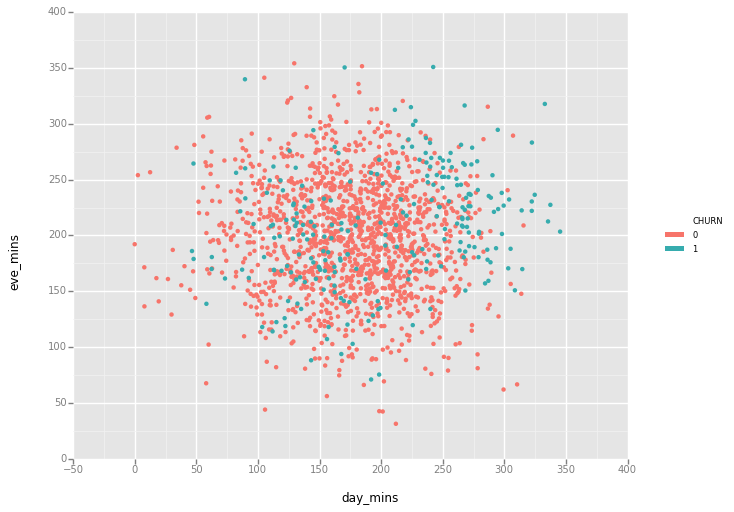

<ggplot: (12447808)>

In [18]:
#Sample data and plot
ex=out[['day_mins','eve_mins','CHURN']].to_frame(sample_pct=.5,stratify_by='CHURN')
ggplot(ex,aes(x='day_mins',y='eve_mins',color='CHURN')) + geom_point()

Ok, we've seen some data manipulations, visualizations, lets do some **<font color=green> machine learning!</font>**

In [19]:
#As usual, load the action sets
conn.loadactionset(actionset="sampling")
conn.loadactionset(actionset="regression")
conn.loadactionset(actionset="decisionTree")

NOTE: Added action set 'sampling'.
NOTE: Added action set 'regression'.
NOTE: Added action set 'decisionTree'.


[actionset]

 'decisionTree'

+ Elapsed: 0.0314s, sys: 0.005s, mem: 0.0305mb

Apply a sampling scheme - we'll use stratified sampling and also return partition indicators

In [20]:
#Conduct Sampling and see the data set
out_smpl=conn.sampling.stratified(
  table={"name":"churn", "groupBy":'churn'},
  output={"casOut":{"name":"churn_part", "replace":True}, "copyVars":"ALL"},
  samppct=70,
  partind=True
)
render_html(conn.CASTable('churn_part').head())

NOTE: Using SEED=2120582530 for sampling.


Selected Rows from Table CHURN_PART 
 account_length 
 vmail_message 
 day_mins 
 eve_mins 
 night_mins 
 intl_mins 
 custserv_calls 
 day_calls 
 day_charge 
 eve_calls 
 eve_charge 
 night_calls 
 night_charge 
 intl_calls 
 intl_charge 
 state 
 phone 
 INTL_PLAN 
 VMAIL_PLAN 
 AREA_CODE 
 CHURN 
 Partition Indicator 
 
 
 128.0 25.0 265.1 197.4 244.7 10.0 1.0 110.0 45.07 99.0 16.78 91.0 11.01 3.0 2.7 KS 382-4657 0 1 415 0 1.0 
 107.0 26.0 161.6 195.5 254.4 13.7 1.0 123.0 27.47 103.0 16.62 103.0 11.45 3.0 3.7 OH 371-7191 0 1 415 0 1.0 
 137.0 0.0 243.4 121.2 162.6 12.2 0.0 114.0 41.38 110.0 10.3 104.0 7.32 5.0 3.29 NJ 358-1921 0 0 415 0 1.0 
 84.0 0.0 299.4 61.9 196.9 6.6 2.0 71.0 50.9 88.0 5.26 89.0 8.86 7.0 1.78 OH 375-9999 1 0 408 0 1.0 
 75.0 0.0 166.7 148.3 186.9 10.1 3.0 113.0 28.34 122.0 12.61 121.0 8.41 3.0 2.73 OK 330-6626 1 0 415 0 1.0

Next let's characterize our variables. Put them into sets or lists (basically sequence types that we can pass as arguments to the ML action calls later). Once again - you can get fancy with an expression or call out the variables

In [21]:
#intialize var sets
noms={'state','area_code','churn','intl_plan','vmail_plan'}
int_vars={'account_length', 'custserv_calls', 'day_calls', 'day_charge', 'day_mins', 'eve_calls',
          'eve_charge', 'eve_mins', 'intl_calls', 'intl_charge', 'intl_mins', 
          'night_calls','night_charge', 'night_mins', 'vmail_message', }
effect_vars={'state','area_code','account_length', 'custserv_calls', 'day_calls', 'day_charge', 
             'day_mins', 'eve_calls','eve_charge', 'eve_mins', 'intl_calls', 
             'intl_charge', 'intl_mins', 'intl_plan','night_calls','night_charge',
             'night_mins', 'vmail_message', 'vmail_plan'}
#you can also easily set these variables up using expression like so -
#int_vars={i for i in cpart.dtypes[cpart.dtypes=='double'].index if i!='_PartInd_'}

In [22]:
cpart = conn.CASTable('CHURN_PART') #reference the partitioned CAS Table
#Run Logistic Regression-- Please note that many of those keyword arguments passed are optional
#Its used here just to demonstrate flexibility
log_reg = cpart.logistic(class_=[dict(vars=noms)],
                                   model={"depvars":[{"name":"churn", "options":{"event":"1"}}],
                                        "effects":[dict(vars=effect_vars)]
                                         },
                                   partbyvar={"name": "_partind_", "train": "1", "valid": "0"},
                                   selection=dict(method="stepwise"),
                                   output=dict(casout=dict(name="churn_scored_logistic",
                                                          replace=True),
                                              copyvars="ALL")
                                  )

render_html(log_reg) 
#if a particular portion of the result is needed something like this can be done as well
#log_reg['SelectedModel.ParameterEstimates']

NOTE: Convergence criterion (GCONV=1E-8) satisfied.


Likelihood Ratio Test 
 Test 
 DF 
 Chi-Square 
 Pr > ChiSq 
 
 
 Likelihood Ratio 8 408.089174480644 3.4832645951414e-83 
 
 
 
 
 Task Timing 
 RowId 
 Task 
 Time 
 Relative Time 
 
 
 SETUP Setup and Parsing 0.00764894485473 0.01943556765827 
 LEVELIZATION Levelization 0.00555300712585 0.01410989982946 
 INITIALIZATION Model Initialization 0.01284790039062 0.03264584096905 
 SSCP SSCP Computation 0.02786421775817 0.07080151573437 
 FITTING Model Selection 0.32321596145629 0.82127480409648 
 OUTPUT Creating Output Data 0.01193189620971 0.03031832239343 
 CLEANUP Cleanup 0.00378894805908 0.00962751827271 
 TOTAL Total 0.39355397224426 1.0 
 
 
 
 
 Selection Summary 
 Control 
 Step 
 Effect Entered 
 Effect Removed 
 Number Of Effects 
 SBC 
 Optimal SBC 
 
 
 0 Intercept 1 1938.17389017485 0 
 - 1 INTL_PLAN 2 1776.09661291428 0 
 2 custserv_calls 3 1711.22318857532 0 
 3 day_charge 4 1643.74311494258 0 
 4 VMAIL_PLAN 5 1621.99814340284 0 
 5 eve_mins 6 1602.36523405769 0 
 6 intl_calls 7 1596.51746133821 0 
 7 intl_charge 8 1593.66568731936 0 
 8 night_mins 9 1592.1427489085 1 
 
 
 
 
 Response Profile 
 Ordered Value 
 CHURN 
 CHURN 
 Total Frequency 
 Training 
 Validation 
 Probability Modeled 
 
 
 1 0 0 2850.0 1995.0 855.0 
 2 1 1 483.0 338.0 145.0 * 
 
 
 
 
 Fit Statistics 
 RowId 
 Description 
 Training 
 Validation 
 
 
 M2LL -2 Log Likelihood 1522.32980542221 647.26744062784 
 AIC AIC (smaller is better) 1540.32980542221 665.26744062784 
 AICC AICC (smaller is better) 1540.40729143168 665.449258809658 
 SBC SBC (smaller is better) 1592.1239978704 709.437238138679 
 ASE Average Square Error 0.09870276503614 0.09898093119455 
 M2LLNULL -2 Log L (Intercept-only) 1930.41897990285 827.874260780447 
 RSQUARE R-Square 0.16047611307155 0.16523649363092 
 ADJRSQ Max-rescaled R-Square 0.28512193812919 0.29348099832404 
 MCFADDEN McFadden's R-Square 0.2113992758718 0.21815730807036 
 MISCLASS Misclassification Rate 0.13459065580797 0.142 
 DIFFMEAN Difference of Means 0.20582880051981 0.19448914169301 
 
 
 
 
 Model Information 
 RowId 
 Description 
 Value 
 
 
 DATA Data Source CHURN_PART 
 RESPONSEVAR Response Variable CHURN 
 DIST Distribution Binary 
 LINK Link Function Logit 
 TECH Optimization Technique Newton-Raphson with Ridging 
 
 
 
 
 Output CAS Tables 
 CAS Library 
 Name 
 Label 
 Number of Rows 
 Number of Columns 
 Table 
 
 
 CASUSER(sasdemo) churn_scored_logistic 3333 23 CASTable('churn_scored_logistic', caslib='CASUSER(sasdemo)') 
 
 
 
 
 Number of Observations 
 RowId 
 Description 
 Total 
 Training 
 Validation 
 
 
 NREAD Number of Observations Read 3333.0 2333.0 1000.0 
 NUSED Number of Observations Used 3333.0 2333.0 1000.0 
 
 
 
 
 Selected Effects 
 Label 
 Effects 
 
 
 Selected Effects: Intercept INTL_PLAN eve_mins night_mins day_charge VMAIL_PLAN custserv_calls intl_charge intl_calls 
 
 
 
 
 Selection Reason 
 Reason 
 
 
 The model at step 8 is selected. 
 
 
 
 
 Dimensions 
 RowId 
 Description 
 Value 
 
 
 NDESIGNCOLS Columns in Design 11 
 NEFFECTS Number of Effects 9 
 MAXEFCOLS Max Effect Columns 2 
 DESIGNRANK Rank of Design 9 
 OPTPARM Parameters in Optimization 9 
 
 
 
 
 Selection Information 
 Description 
 Value 
 Numeric Value 
 
 
 Selection Method Stepwise nan 
 Select Criterion SBC nan 
 Stop Criterion SBC nan 
 Effect Hierarchy Enforced None nan 
 Stop Horizon 3 3.0 
 
 
 
 
 Class Level Information 
 Class 
 Levels 
 Values 
 
 
 AREA_CODE 3.0 408 415 510 
 INTL_PLAN 2.0 0 1 
 VMAIL_PLAN 2.0 0 1 
 state 51.0 AK AL AR AZ CA CO CT DC DE FL GA HI IA ID IL IN KS KY LA MA MD ME MI MN MO MS MT NC ND NE NH NJ NM NV NY OH OK OR PA RI SC SD TN TX UT VA VT WA WI WV WY 
 
 
 
 
 Stop Reason 
 Reason 
 Code 
 
 
 Stepwise selection stopped because adding or removing an effect does not improve the SBC criterion. 8 
 
 
 
 
 Parameter Estimates 
 Effect 
 INTL_PLAN 
 VMAIL_PLAN 
 Parameter 
 Parameter 
 DF 
 Estimate 
 Standard Error 
 Chi-Square 
 Pr > ChiSq 
 
 
 Intercept Inte

Obviously,you can also **<font color='green'>run SAS data step</font>** code to create new variables!

In [23]:
# Compute _pred0_ variable (1-_pred_)
conn.dataStep.runCode(
  code="data churn_scored_logistic; set churn_scored_logistic; _pred0_=1-_pred_; run;"
)

,casLib,Name,Rows,Columns,casTable
0,CASUSER(sasdemo),churn_scored_logistic,3333,24,"CASTable('churn_scored_logistic', caslib='CASU..."
,casLib,Name,Rows,Columns,casTable
0,CASUSER(sasdemo),churn_scored_logistic,3333,23,"CASTable('churn_scored_logistic', caslib='CASU..."


Next, **Random Forest Model**

In [24]:
#Model Training - 
##1.Train the model on the training data
##2.Get important variables
##3. Write the model definition into a table
r_forest=cpart[cpart['_PartInd_']==1].decisiontree.foresttrain(inputs=effect_vars,
                                                               target="churn",
                                                               varimp=True,
                                                               event='1',
                                                              casout=dict(name="rf_model",
                                                              replace=True),
                                                              savestate=dict(name='forest_model_train',
                                                                             replace=True)
                                                                            )

r_forest #look at the results

NOTE: Wrote 720985 bytes to the savestate file forest_model_train.


,Variable,Importance,Std
0,custserv_calls,21.69,16.79
1,day_charge,19.84,7.72
2,day_mins,15.90,7.56
3,INTL_PLAN,12.26,6.68
4,intl_calls,6.33,11.02
5,VMAIL_PLAN,3.29,4.89
6,intl_charge,2.40,7.42
7,intl_mins,2.23,5.49
8,eve_mins,2.10,2.62
9,eve_charge,1.16,2.10


Model scoring is simple!

In [25]:
#Model Scoring
cpart.forestscore(modeltable='rf_model',
                 casout=dict(name="scored_rf_data",
                             replace=True),
                 copyVars={"churn","_partind_"},
                  vote="PROB")

[OutputCasTables]

              casLib            Name  Rows  Columns  \
 0  CASUSER(sasdemo)  scored_rf_data  3333        7   
 
                                             casTable  
 0  CASTable('scored_rf_data', caslib='CASUSER(sas...  

[ScoreInfo]

                          Descr                             Value
 0  Number of Observations Read                              3333
 1  Number of Observations Used                              3333
 2  Misclassification Error (%)                      12.391239124

+ Elapsed: 0.0585s, user: 0.156s, sys: 0.005s, mem: 17.4mb

In [26]:
conn.fedsql.execdirect("""create table casuser.churn_scored_rf {options replace=true} as
                       (select *,
                       case when _rf_predname_=1 then _rf_predp_ else 1-_rf_predp_ end as _pred_,
                       case when _rf_predname_=0 then _rf_predp_ else 1-_rf_predp_ end as _pred0_
                       from casuser.scored_rf_data
                       )
                       """)

#sneak peek at the data
dat=conn.CASTable('churn_scored_rf')
dat[dat['_RF_PredName_']>0].head() #show me some churn events

NOTE: Table CHURN_SCORED_RF was created in caslib CASUSER(sasdemo) with 3333 rows returned.


,CHURN,_PartInd_,_RF_PredName_,_RF_PredP_,_RF_PredLevel_,_MissIt_,_Vote_,_PRED_,_PRED0_
0,1,1.00,1,0.92,1.00,0.00,45.90,0.92,0.08
1,1,1.00,1,0.52,1.00,0.00,25.79,0.52,0.48
2,1,1.00,1,0.53,1.00,0.00,26.47,0.53,0.47
3,1,1.00,1,0.95,1.00,0.00,47.64,0.95,0.05
4,1,0.00,1,0.91,1.00,0.00,45.64,0.91,0.09


We'll use the table above to assess the model - however we'll just use the validation data set.
We'll do this for both the RF and Log. Reg models

In [27]:
#Simple Pandas Style Subsetting to create validation data references for both Log Reg and RF
#get a CASTable Ref
scored_data_log=conn.CASTable('churn_scored_logistic', caslib='casuser')
scored_data_forest=conn.CASTable('churn_scored_rf',caslib='casuser')
#Easy subsetting
valid_data_logistic=scored_data_log[scored_data_log['_PartInd_']==0]  #subset for Log Reg
valid_data_rf =scored_data_forest[scored_data_forest['_PartInd_']==0] #subset for RF

Helper function for model assessment - it generates and collects the validation metrics

In [28]:
def assess_model(validation_dataset,suffix):
    """This funtion calls the assessment action with the appropriate settings
    on the dataset passed"""
    return validation_dataset.assess(
      inputs=[{"name":"_pred_"}],      
      response="churn",
      event="1",
      pVar={"_pred0_"},
      pEvent={"0"}      
    )

Only Pick Up metrics we care about

In [29]:
#Pick up all assessmet Metrics
logistic_assess=assess_model(validation_dataset=valid_data_logistic,suffix='logistic')    
logistic_fitstat =logistic_assess.FitStat
logistic_rocinfo =logistic_assess.ROCInfo
logistic_liftinfo=logistic_assess.LIFTInfo

rf_assess=assess_model(validation_dataset=valid_data_rf,suffix='rf')    
rf_fitstat =rf_assess.FitStat
rf_rocinfo =rf_assess.ROCInfo
rf_liftinfo=rf_assess.LIFTInfo

Some final simple data prep work for model assessment - also note,at this point eveything is happening on the client side

In [30]:
# Add new variable to indicate type of model
logistic_liftinfo["model"]="Logistic Regression"
logistic_rocinfo["model"]="Logistic Regression"
rf_liftinfo["model"]="Forest"
rf_rocinfo["model"]="Forest"
#Get lift and ROC info together
all_liftinfo=rf_liftinfo.append(logistic_liftinfo, ignore_index=True)
all_rocinfo=rf_rocinfo.append(logistic_rocinfo, ignore_index=True)

And, the metrics we care about AUC, the ROC Curve and the lift chart..

In [31]:
print("AUC (using validation data)".center(80, '-'))
all_rocinfo[["model", "C"]].drop_duplicates(keep="first").sort_values(by="C", ascending=False)

--------------------------AUC (using validation data)---------------------------


,model,C
0,Forest,0.87
100,Logistic Regression,0.82


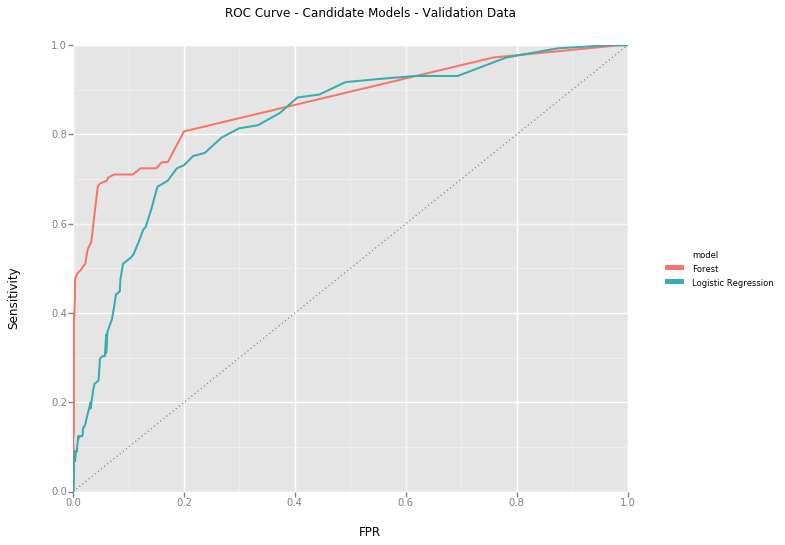

<ggplot: (-9223372036841798200)>

In [32]:
#model_groups=all_rocinfo.groupby('model')
ggplot(all_rocinfo, aes(x='FPR', y='Sensitivity',color='model')) +\
    geom_line(linetype='solid',size=2) +\
    geom_abline(linetype='dotted') +\
    ggtitle('ROC Curve - Candidate Models - Validation Data')

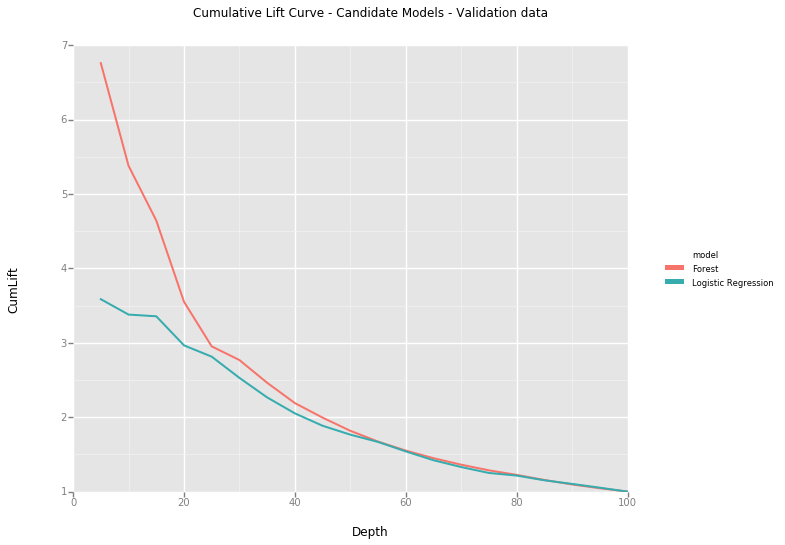

<ggplot: (13656005)>

In [33]:
ggplot(all_liftinfo, aes(x='Depth', y='CumLift',color='model')) +\
    geom_line(linetype='solid',size=2) +\
    ggtitle('Cumulative Lift Curve - Candidate Models - Validation data')

```python
# Alternatively using Matplotlib
#/* Draw ROC charts */ 
plt.figure()
for key, grp in all_rocinfo.groupby(["model"]):
    plt.plot(grp["FPR"], grp["Sensitivity"], label=key)
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend(loc="best")
plt.title("ROC Curve (using validation data)")
plt.show()

#/* Draw lift charts */
plt.figure()
for key, grp in all_liftinfo.groupby(["model"]):
    plt.plot(grp["Depth"], grp["Lift"], label=key)
plt.xlabel("Depth")
plt.ylabel("Lift")
plt.grid(True)
plt.legend(loc="best")
plt.title("Lift Chart (using validation data)")
plt.show()```

Promote any of the data sets to the global scope if needed..

In [34]:
conn.table.promote(name='churn',drop=True, targetlib='public')

+ Elapsed: 0.00333s, user: 0.001s, sys: 0.002s, mem: 0.0345mb

In [35]:
conn.table.save(table='FOREST_MODEL_TRAIN', caslib='casuser',
                name ='forest_model_champ.sashdat', replace=True)

NOTE: Cloud Analytic Services saved the file forest_model_champ.sashdat in caslib CASUSER(sasdemo).


[name]

 'forest_model_champ.sashdat'

[caslib]

 'CASUSER(sasdemo)'

+ Elapsed: 0.126s, user: 0.001s, sys: 0.004s, mem: 16.1mb

In [36]:
conn.loadactionset("astore")

NOTE: Added action set 'astore'.


[actionset]

 'astore'

+ Elapsed: 0.129s, user: 0.000999s, sys: 0.001s, mem: 0.0298mb

In [37]:
conn.astore.describe("FOREST_MODEL_TRAIN")

[Description]

 Run Information
 
          Attribute               Value
 0  Analytic Engine              forest
 1     Time Created  25Aug2017:13:38:54

[InputVariables]

 Input Variables
 
               Name  Length    Role            Type RawType FormatName
 0        INTL_PLAN    1.00   Input  Classification    Char           
 1         day_mins    8.00   Input        Interval     Num           
 2    vmail_message    8.00   Input        Interval     Num           
 3        eve_calls    8.00   Input        Interval     Num           
 4         eve_mins    8.00   Input        Interval     Num           
 5        intl_mins    8.00   Input        Interval     Num           
 6       night_mins    8.00   Input        Interval     Num           
 7      night_calls    8.00   Input        Interval     Num           
 8       day_charge    8.00   Input        Interval     Num           
 9   account_length    8.00   Input        Interval     Num           
 10    night_charge    8.00   Input        Interval     Num           
 11       AREA_CODE    3.00   Input  Classification    Char           
 12      VMAIL_PLAN    1.00   Input  Classification    Char           
 13       day_calls    8.00   Input        Interval     Num           
 14      eve_charge    8.00   Input        Interval     Num           
 15  custserv_calls    8.00   Input        Interval     Num           
 16     intl_charge    8.00   Input        Interval     Num           
 17      intl_calls    8.00   Input        Interval     Num           
 18           state    2.00   Input  Classification    Char           
 19           CHURN    1.00  Target  Classification    Char           

[Key]

 Store Key
 
                                         Key
 0  2800895224A3F463475F5AB84A1E46E50DC3A824

[OutputVariables]

 Output Variables
 
        Name  Length  Type               Label
 0  P_CHURN0    8.00   Num  Predicted: CHURN=0
 1  P_CHURN1    8.00   Num  Predicted: CHURN=1
 2   I_CHURN   32.00  Char         Into: CHURN
 3    _WARN_    4.00  Char            Warnings

+ Elapsed: 0.0754s, user: 0.06s, sys: 0.005s, mem: 9mb

In [38]:
#conn.close()